Semi-supervised learning.  
Future-prediction CAE network.  
Use 3d spatio-temporal conv kernels.  

In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
from torch.nn import functional as F
from torch.autograd import Variable

import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set(color_codes=True)
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
import h5py
import cv2
from scipy.stats import pearsonr#Pearson correlation coefficient
from sklearn.decomposition import randomized_svd
from scipy.signal import find_peaks
import datetime
import time
import pandas as pd
import pickle as pkl
#import winsound#sound alarm when code finishes, only in windows

from SemiNE3d.utils import *
from SemiNE3d.train import *
from chirpMB import *

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

In [2]:
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed(1)
torch.backends.cudnn.deterministic=True
np.random.seed(1)
torch.manual_seed(1)    # reproducible
#
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device_cpu=torch.device('cpu')
#device=torch.device('cpu')
EPOCH = 100
#BATCH_SIZE = 1000 #100
#LR = 0.05#original
LR=2e-4 # 1e-4
L2=0.0#L2=0.000001#L2 regularization

In [3]:
print (torch.cuda.is_available())

True


In [4]:
# for plot figures
plt.rcParams.update({'figure.max_open_warning': 0})
#Output matplotlib figure to SVG with text as text, not curves
plt.rcParams['svg.fonttype'] = 'none'
# axis spine
#use it like: adjust_spines(ax, ['left', 'bottom'])
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 2))  # outward by 2 points
            #spine.set_smart_bounds(True)
        else:
            spine.set_color('none')  # don't draw spine
    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])

In [5]:
training_inputs = np.load('../data/fig6_training_inputs.npy')
training_set = np.load('../data/fig6_training_set.npy')
test_inputs = np.load('../data/fig6_test_inputs.npy')
test_set = np.load('../data/fig6_test_set.npy')
movie_bgr_h5 = np.load('../data/fig6_movie_bgr_h5.npy')

In [6]:
#split original training data into two parts, training loader: 2200, validation loader: 200
#make the dataset suitable for pytorch and semi-supervised learning
train_loader=[]
'''
for ii in range(20):
    #neural data
    temp0=training_inputs[ii*110:ii*110+110] -0.5 #center the stimulus
    temp1=training_set[ii*110:ii*110+110]#100*200(neurons)
    #natural image data
    temp2=movie_bgr_h5[ii*1800:ii*1800+1800] # [ii*1800:ii*1800+1800]
    temp=(temp0,temp1,temp2)
    train_loader.append(temp)
'''
'''
for ii in range(8): # 40% of data
    #neural data
    temp0=training_inputs[ii*110:ii*110+110] -0.5 #center the stimulus
    temp1=training_set[ii*110:ii*110+110]#100*200(neurons)
    #natural image data
    temp2=movie_bgr_h5[ii*4500:ii*4500+4500] # [ii*1800:ii*1800+1800]
    temp=(temp0,temp1,temp2)
    train_loader.append(temp)
'''
for ii in range(12): # 60% of data
    #neural data
    temp0=training_inputs[ii*110:ii*110+110] -0.5 #center the stimulus
    temp1=training_set[ii*110:ii*110+110]#100*200(neurons)
    #natural image data
    temp2=movie_bgr_h5[ii*3000:ii*3000+3000] 
    temp=(temp0,temp1,temp2)
    train_loader.append(temp)
#
temp0=training_inputs[2200:] -0.5 #center the stimulus
temp1=training_set[2200:]#200*200(neurons)
temp2=movie_bgr_h5[36000:39200]
#val_loader=(temp0,temp1)
val_loader=(temp0,temp1,temp2)
#
temp0=np.copy(test_inputs) -0.5 #center the stimulus
temp1=np.copy(test_set)#50*200(neurons)
temp2=movie_bgr_h5[39200:]
#test_loader=(temp0,temp1)
test_loader=(temp0,temp1,temp2)
#
print ('length of train_loader:')
print (len(train_loader))
print ('shape of train_loader[0][0]:')
print (train_loader[0][0].shape)
print ('shape of train_loader[0][1]:')
print (train_loader[0][1].shape)
print ('shape of train_loader[0][2]:')
print (train_loader[0][2].shape)
#
print ('shape of val_loader[0]:')
print (val_loader[0].shape)
print ('shape of val_loader[1]:')
print (val_loader[1].shape)
print ('shape of val_loader[2]:')
print (val_loader[2].shape)
#
print ('shape of test_loader[0]:')
print (test_loader[0].shape)
print ('shape of test_loader[1]:')
print (test_loader[1].shape)
print ('shape of test_loader[2]:')
print (test_loader[2].shape)

length of train_loader:
12
shape of train_loader[0][0]:
(110, 2, 8, 28, 28)
shape of train_loader[0][1]:
(110, 427)
shape of train_loader[0][2]:
(3000, 2, 9, 28, 28)
shape of val_loader[0]:
(200, 2, 8, 28, 28)
shape of val_loader[1]:
(200, 427)
shape of val_loader[2]:
(3200, 2, 9, 28, 28)
shape of test_loader[0]:
(50, 2, 8, 28, 28)
shape of test_loader[1]:
(50, 427)
shape of test_loader[2]:
(800, 2, 9, 28, 28)


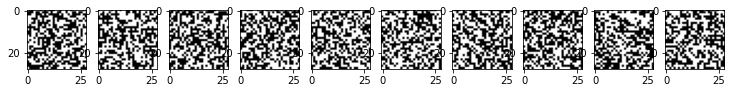

In [7]:
#visualize everything after making train and test loader
fig, axes = plt.subplots(nrows=1, ncols=10,figsize=(12.5,2.5))
for ii in range(10):
    axes[ii].imshow(train_loader[0][0][ii][0][0],cmap='gray',vmin=-0.5,vmax=0.5)
    axes[ii].grid(False)#axes[ii,jj].axis('tight')

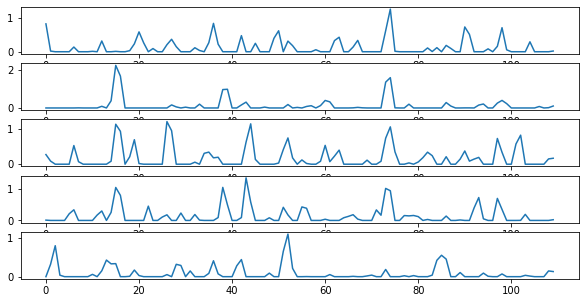

In [8]:
#visualize everything after making train and test loader
fig, axes = plt.subplots(nrows=5, ncols=1,figsize=(10,5))
for ii in range(5):
    axes[ii].plot(train_loader[0][1][:,ii])

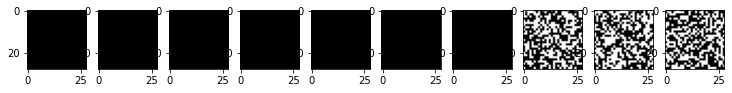

In [9]:
#visualize everything after making train and test loader
fig, axes = plt.subplots(nrows=1, ncols=10,figsize=(12.5,2.5))
for ii in range(10):
    axes[ii].imshow(test_loader[0][ii][0][0],cmap='gray',vmin=-0.5,vmax=0.5)
    axes[ii].grid(False)#axes[ii,jj].axis('tight')

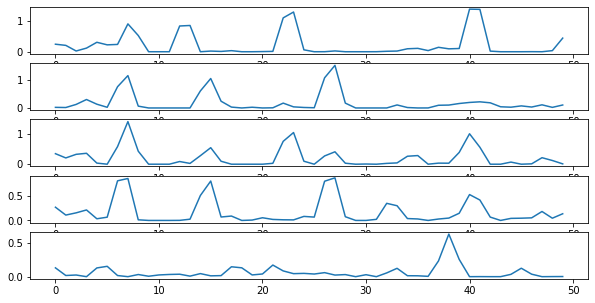

In [10]:
#visualize everything after making train and test loader
fig, axes = plt.subplots(nrows=5, ncols=1,figsize=(10,5))
for ii in range(5):
    axes[ii].plot(test_loader[1][:,ii])
    #axes[ii].grid(False)#axes[ii,jj].axis('tight')

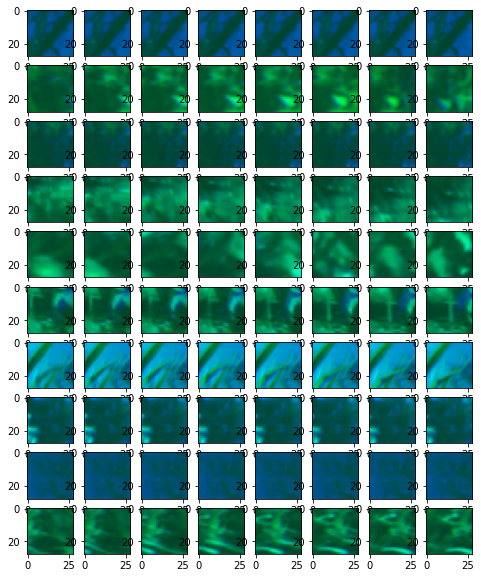

In [11]:
fig, axes = plt.subplots(nrows=10, ncols=8,figsize=(8,10))
for ii in range(10):
    for jj in range(8):
        temp=np.zeros((28,28,3),np.uint8)
        temp[...,1:]=np.transpose(train_loader[5][2][ii][:,jj,:,:],(1,2,0))[...,::-1]
        axes[ii,jj].imshow(img_real2view(temp))
        axes[ii,jj].grid(False)#axes[ii,jj].axis('tight')

In [12]:
#preprocess: centered data
#sky_bg_mean_f   =(0.10539950580232095, 0.23792787064825932)
sky_bg_mean_f   = np.mean(movie_bgr_h5[:36000,:,:-1,:,:],axis=(0,2,3,4))/255.0
print(sky_bg_mean_f)

[0.19401256 0.20572354]


In [13]:
#function: visualize conv0 weights
def Vis_conv3d_0(conv3d_0,temptitle,save=False,filename=None): # conv3d_0.shape (16, 2, 8, 9, 9)
    (outd,_,_,_,_)=conv3d_0.shape
    fig, axes = plt.subplots(nrows=3, ncols=outd,figsize=(outd, 3))
    for jj in range(outd):
        nt = 8 # time lag
        ny = 9
        nx = 9
        dims = [nt, ny, nx]
        [sRF_UV, tRF_UV]=mySVD(conv3d_0[jj,0], dims)
        [sRF_G, tRF_G]=mySVD(conv3d_0[jj,1], dims)
        tempmax=np.max(np.abs([sRF_UV,sRF_G]))
        axes[0,jj].imshow(sRF_UV,vmin=-tempmax,vmax=tempmax,cmap='bwr')
        axes[0,jj].set_xticks([])
        axes[0,jj].set_yticks([])
        axes[0,jj].set_title('%d' %(jj))
        axes[1,jj].imshow(sRF_G,vmin=-tempmax,vmax=tempmax,cmap='bwr')
        axes[1,jj].set_xticks([])
        axes[1,jj].set_yticks([])
        axes[2,jj].plot(tRF_G,color='g')
        axes[2,jj].plot(tRF_UV,color='purple')
        axes[2,jj].axhline(y=0,color='k')
        axes[2,jj].spines['left'].set_visible(False)
        axes[2,jj].spines['bottom'].set_visible(False)
        axes[2,jj].spines['right'].set_visible(False)
        axes[2,jj].spines['top'].set_visible(False)
        axes[2,jj].set_xticks([])
        axes[2,jj].set_yticks([])
        axes[0,0].set_ylabel(str(temptitle))
        axes[0,0].set_title('%d_UV' %(0))
    if save==True:
        fig.savefig(filename)

##  <font color='red'>Model architecture</font> 

In [14]:
class ModelSemiSL3d1_Conv3d_2(nn.Module):
    def __init__(self):
        super().__init__()
        #supervised
        self.numoffea=16 #number of features
        self.sizeoffea=20*20 #size of feature
        self.numofneuron=427 #number of neurons
        self.conv1=nn.Parameter(torch.zeros(self.numoffea,2,8,9,9))
        std=1. / np.sqrt(2*8*9*9)
        self.conv1.data.uniform_(-std, std)
        self.conv1_bias=nn.Parameter(torch.zeros(self.numoffea))
        self.conv1_bias.data.uniform_(-std, std)
        self.fc1=nn.Linear(self.numoffea*self.sizeoffea,self.numofneuron)
        #autoencoder
        #
        self.ae_dconv1 =nn.ConvTranspose2d(self.numoffea,2,kernel_size=9,stride=1,padding=4) #2,28*28
        self.ae_fc1    =nn.Linear(self.numoffea*28*28,self.numoffea*28*28)
        self.ae_dfc1   = nn.Linear(self.numoffea*28*28,self.numoffea*28*28)
        self.ae_encoder = nn.Sequential(
            #self.conv1, #16,28*28
            nn.ReLU(),
            Flatten3D(),
            self.ae_fc1,
            nn.ReLU(),
            #GaussianNoise(sigma=0)
        )
        self.ae_decoder = nn.Sequential(
            self.ae_dfc1,
            nn.ReLU(),
            Unflatten(-1,self.numoffea,28,28),
            self.ae_dconv1, #2,28*28
            nn.Tanh())
    #
    def forward(self, x, z):
        #supervised
        encoded = F.relu(F.conv3d(x, self.conv1, bias=self.conv1_bias,stride=1,padding=(0,0,0))) #16,20*20
        encoded = encoded.view(-1,self.numoffea*self.sizeoffea)
        encoded = torch.exp(self.fc1(encoded))
        #autoencoder
        #z          = z.unsqueeze(2) 
        ae_encoded = F.conv3d(z, self.conv1, bias=self.conv1_bias,stride=1,padding=(0,4,4))
        ae_encoded = self.ae_encoder(ae_encoded)
        ae_decoded = self.ae_decoder(ae_encoded)
        #ae_decoded = ae_decoded.squeeze(2) 
        return encoded, ae_encoded, ae_decoded
#for visualization of RFs
class ModelSemiSL3d1_Conv3d_2_copy(nn.Module):
    def __init__(self,conv1,conv1_bias,fc1_weight,fc1_bias):
        super().__init__()
        self.numoffea=16 #number of features
        self.sizeoffea=20*20 #size of feature
        self.numofneuron=427 #number of neurons
        self.conv1=nn.Parameter(torch.zeros(self.numoffea,2,8,9,9))
        std=1. / np.sqrt(2*8*9*9)
        self.conv1.data.uniform_(-std, std)
        self.conv1_bias=nn.Parameter(torch.zeros(self.numoffea))
        self.conv1_bias.data.uniform_(-std, std)
        self.fc1=nn.Linear(self.numoffea*self.sizeoffea,self.numofneuron)
        #
        self.conv1.data.copy_(conv1.clone().detach())
        self.conv1_bias.data.copy_(conv1_bias.clone().detach())
        self.fc1.weight.data.copy_(fc1_weight.clone().detach())
        self.fc1.bias.data.copy_(fc1_bias.clone().detach())
    #
    def forward(self, x):
        encoded = F.relu(F.conv3d(x, self.conv1, bias=self.conv1_bias,stride=1,padding=(0,0,0))) #16,20*20
        encoded = encoded.view(-1,self.numoffea*self.sizeoffea)
        encoded = torch.exp(self.fc1(encoded))
        return encoded

In [ ]:
#best model: alpha3s =[1e5], beta2s =[1/4], lossweights=[0.7]
EPOCH=100 
LR=3e-4 
batch_nums = [6] # [4, 6, 8, 10, 12]
alpha1s = [1e3]  # 
alpha2s = [0] #not play a role
beta1s  = [1/16] # 
alpha3s = [1e5]  # 
beta2s  = [1/4] # 
seeds   = [1]
lossweights=[0.7] # [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
#modeltrainloss=[]
modelvalloss=[]
for gg in range(len(batch_nums)):
    bnum = str(gg+2) #batch number
    for ii in range(len(seeds)):
        for jj in range(len(lossweights)):
            seedname=str(ii+1) #start from first seed
            modelname=str(jj+4) # modelname=1 and 9
            torch.manual_seed(seeds[ii])    # reproducible
            torch.cuda.manual_seed(seeds[ii])
            tempmodel = ModelSemiSL3d1_Conv3d_2()
            optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
            model_train(tempmodel,train_loader[:batch_nums[gg]],optimizer,device,EPOCH,loss_SemiSL,sky_bg_mean_f,val_loader,\
                    alpha1=alpha1s[0],alpha2=alpha2s[0],\
                    beta1=beta1s[0],alpha3=alpha3s[0],beta2=beta2s[0],lossweight=lossweights[jj],earlystop=True,verbose=False) 
            #modeltrainloss.append(temp)
            #
            torch.save(tempmodel.state_dict(),\
            './out/20200429_v5_ModelSemiSL3d1_Conv3d_2_ventral_less_upandlow_bnum_'+bnum+'_seed_'+seedname+'_weight_'+modelname+'.pth')
            temp=model_val(tempmodel,val_loader,1,device_cpu,sky_bg_mean_f)
            modelvalloss.append(temp)
            del tempmodel
            torch.cuda.empty_cache()